In [1]:
import pandas as pd




In [3]:
# Define the distance matrix data
data = [
    [0, 2, 8, 10, 9],   # P
    [2, 0, 5, 8, 8],    # Q
    [8, 5, 0, 4, 5],    # R
    [10, 8, 4, 0, 3],   # S
    [9, 8, 5, 3, 0]     # T
]

# Define labels
labels = ['P', 'Q', 'R', 'S', 'T']

# Create DataFrame
df = pd.DataFrame(data, index=labels, columns=labels)

print(df)

    P  Q  R   S  T
P   0  2  8  10  9
Q   2  0  5   8  8
R   8  5  0   4  5
S  10  8  4   0  3
T   9  8  5   3  0


In [4]:
# check that all the distances are symmetric
assert (df.values == df.values.T).all(), "Distance matrix is not symmetric"

In [9]:
# check that d_ij >= d_ik + d_kj for all i, j, k
n = len(labels)
for start in range(n):
    for end in range(n):
        for k in range(n):
            if df.iloc[start, end] > df.iloc[start, k] + df.iloc[k, end]:
                # print(f"Triangle inequality violated for {labels[start]}, {labels[end]}, {labels[k]}")
                print(f'When we start at {labels[start]} and end at {labels[end]}, going through {labels[k]} is shorter: {df.iloc[start, k]} + {df.iloc[k, end]} < {df.iloc[start, end]}')
                # raise ValueError(f"Triangle inequality violated for {labels[i]}, {labels[j]}, {labels[k]}")
print("All distances are symmetric and satisfy the triangle inequality.")

When we start at P and end at R, going through Q is shorter: 2 + 5 < 8
When we start at R and end at P, going through Q is shorter: 5 + 2 < 8
All distances are symmetric and satisfy the triangle inequality.


Linkage matrix (SciPy format):
 [[0. 1. 2. 2.]
 [3. 4. 3. 2.]
 [2. 6. 4. 3.]
 [5. 7. 5. 5.]]


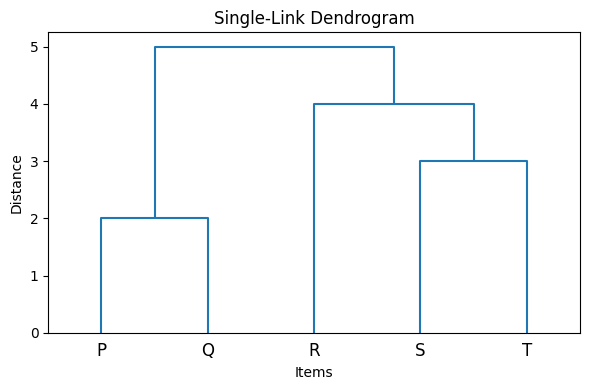

In [10]:
# Single-link hierarchical clustering for:
# P Q R S T with the given distance matrix

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

labels = ["P", "Q", "R", "S", "T"]

# Full symmetric distance matrix (from the question)
D = np.array([
    [0,  2,  8, 10,  9],
    [2,  0,  5,  8,  8],
    [8,  5,  0,  4,  5],
    [10, 8,  4,  0,  3],
    [9,  8,  5,  3,  0],
], dtype=float)

# Convert to condensed vector that scipy.linkage expects
# (upper triangle, row-wise: PQ, PR, PS, PT, QR, QS, QT, RS, RT, ST)
condensed = squareform(D)

# Single-link agglomerative clustering
Z = linkage(condensed, method="single")

# Show the linkage table
# Columns: [idx/cluster_a, idx/cluster_b, merge_distance, new_cluster_size]
print("Linkage matrix (SciPy format):\n", Z)

# Plot dendrogram
plt.figure(figsize=(6, 4))
dendrogram(Z, labels=labels, color_threshold=0)  # show all merges
plt.title("Single-Link Dendrogram")
plt.xlabel("Items")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


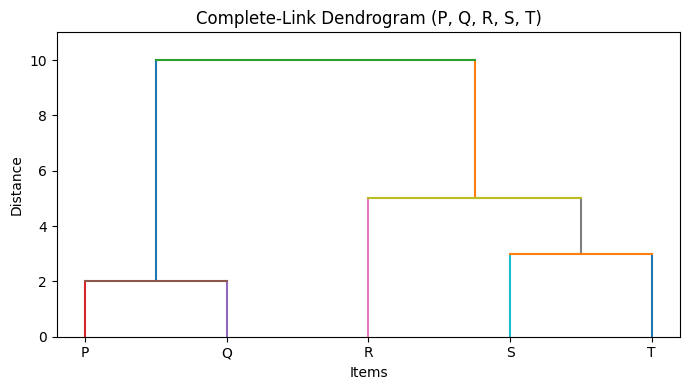

Linkage steps (idA, idB, height, size):
(0, 1, 2.0, 2)
(3, 4, 3.0, 2)
(2, 6, 5.0, 3)
(5, 7, 10.0, 5)


In [11]:
# Complete-link hierarchical clustering and dendrogram (no SciPy needed)
# Items: P, Q, R, S, T with the provided distance matrix

import matplotlib.pyplot as plt

labels = ["P","Q","R","S","T"]
n = len(labels)

# Distance matrix as given in the problem
D = [
    [0,  2,  8, 10,  9],
    [2,  0,  5,  8,  8],
    [8,  5,  0,  4,  5],
    [10, 8,  4,  0,  3],
    [9,  8,  5,  3,  0],
]

# --- Complete-link agglomerative clustering (pure Python) ---
from math import inf

class Node:
    def __init__(self, members, left=None, right=None, height=0.0, name=None):
        self.members = members  # set of leaf indices
        self.left = left
        self.right = right
        self.height = height
        self.name = name  # only for leaves

# Initialize clusters as leaves
clusters = {i: Node({i}, name=labels[i]) for i in range(n)}
active_ids = list(clusters.keys())
next_id = n

# Helper to get complete-link distance between two clusters
def cl_dist(a_ids, b_ids):
    m = -inf
    for i in a_ids:
        for j in b_ids:
            if D[i][j] > m:
                m = D[i][j]
    return m

# Precompute pairwise distances between current clusters (by id)
def compute_pairwise(active_ids):
    pair_d = {}
    for i in range(len(active_ids)):
        for j in range(i+1, len(active_ids)):
            ai, aj = active_ids[i], active_ids[j]
            pair_d[(ai, aj)] = cl_dist(clusters[ai].members, clusters[aj].members)
    return pair_d

linkage = []  # (idA, idB, height, size)

while len(active_ids) > 1:
    pair_d = compute_pairwise(active_ids)
    # Find pair with minimal complete-link distance
    (best_a, best_b), best_d = min(pair_d.items(), key=lambda kv: kv[1])

    # Merge
    A, B = clusters[best_a], clusters[best_b]
    merged_members = A.members | B.members
    new_node = Node(merged_members, left=A, right=B, height=float(best_d))
    clusters[next_id] = new_node

    # Record linkage-like info
    linkage.append((best_a, best_b, float(best_d), len(merged_members)))

    # Update active set
    active_ids = [cid for cid in active_ids if cid not in (best_a, best_b)]
    active_ids.append(next_id)
    next_id += 1

# Root of the tree
root_id = active_ids[0]
root = clusters[root_id]

# --- Layout and plot dendrogram (simple custom plotting) ---
# Assign x positions to leaves in the order of `labels`
leaf_x = {i: x for x, i in enumerate(range(n))}

def assign_positions(node):
    if node.left is None and node.right is None:
        return leaf_x[next(iter(node.members))], 0  # x, y not used here
    x_left, _ = assign_positions(node.left)
    x_right, _ = assign_positions(node.right)
    x_here = (x_left + x_right) / 2.0
    return x_here, 0

# Collect segments to draw (vertical and horizontal lines)
segments = []  # each as ((x1, y1), (x2, y2))

def collect_segments(node):
    if node.left is None and node.right is None:
        return
    # Positions
    def get_x(n):
        if n.left is None and n.right is None:
            return leaf_x[next(iter(n.members))]
        # average of children
        return (get_x(n.left) + get_x(n.right)) / 2.0

    xl = get_x(node.left)
    xr = get_x(node.right)
    xc = (xl + xr) / 2.0

    # Left vertical: from left child height up to current height
    segments.append(((xl, node.left.height), (xl, node.height)))
    # Right vertical
    segments.append(((xr, node.right.height), (xr, node.height)))
    # Horizontal connector at current height
    segments.append(((xl, node.height), (xr, node.height)))

    collect_segments(node.left)
    collect_segments(node.right)

collect_segments(root)

# Plot
plt.figure(figsize=(7, 4))
for (x1,y1),(x2,y2) in segments:
    plt.plot([x1, x2], [y1, y2])
plt.xticks(range(n), labels)
plt.xlabel("Items")
plt.ylabel("Distance")
plt.title("Complete-Link Dendrogram (P, Q, R, S, T)")
plt.ylim(0, max(node.height for node in clusters.values()) * 1.1)
plt.tight_layout()
plt.show()

# Also print the linkage-like steps
print("Linkage steps (idA, idB, height, size):")
for step in linkage:
    print(step)
